In [6]:
from lmdec.decomp.iter_methods import PowerMethod, SuccessiveStochasticPowerMethod
from lmdec.array.core import rmse_k
from lmdec.array.core.transform import acc_format_svd
from lmdec.array.core.random import array_constant_partition
import dask.array as da
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import zarr

In [3]:
array_file_path = '/Users/tnonet/Documents/SNP_matrices/p_by_n/20K_5K.zarr'

assert os.path.isdir(array_file_path)

root = zarr.open(array_file_path, mode='r')
snp_array = da.from_zarr(root)

# Power Method vs Successive Stochastic Power Method

In [4]:
k = 10
maxiter = 50
b=10
tol_limit = 1e-6
score = 'q-vals'
f = .1

In [25]:
PM_results = {'SVD': [], 'PM': []}
vec_t = k + b
n, p = snp_array.shape
partitions = array_constant_partition((n, p), p=f, min_size=vec_t)
first, *partitions = partitions
sub_array = snp_array[first, :]
for i in range(0, 10):
    print(i)
    _PM = PowerMethod(max_iter=maxiter, k=k, buffer=b,
                      tol=tol_limit, scoring_method=score, track_metrics=True)
    
    U, S, V = _PM.svd(sub_array)
    PM_results['SVD'].append([U, S, V])
    PM_results['PM'].append(_PM)
    print(_PM.time)
    try:
        sub_array = da.vstack([sub_array, snp_array[partitions[i], :]])
    except:
        break

0
37.35600423812866
1
47.6981520652771
2
60.64810395240784
3
68.5578498840332
4
76.02655005455017
5
86.32951283454895
6
92.64174890518188
7
99.5971930027008
8
103.52927923202515
9
107.90887022018433


(18000, 5000)

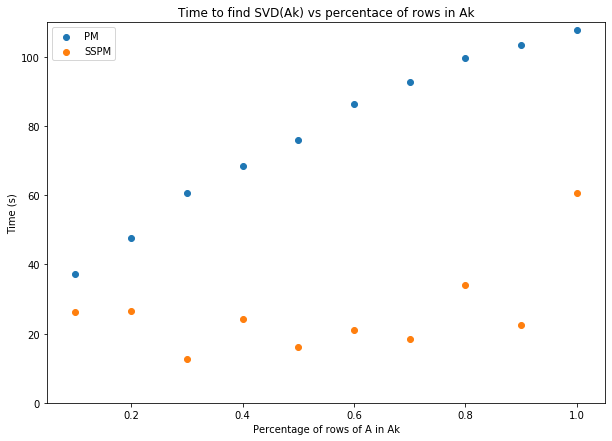

In [74]:
times = [i.time for i in PM_results['PM']]
perc = np.linspace(.1, 1, 10)
fig = plt.figure(figsize=(10,7))
plt.scatter(perc, times, label = 'PM')
plt.scatter(perc, SSPM.time_iterations, label = 'SSPM')
plt.legend()
plt.title('Time to find SVD(Ak) vs percentace of rows in Ak')
plt.ylabel("Time (s)")
plt.xlabel('Percentage of rows of A in Ak')
plt.ylim(0, 110)
plt.show()

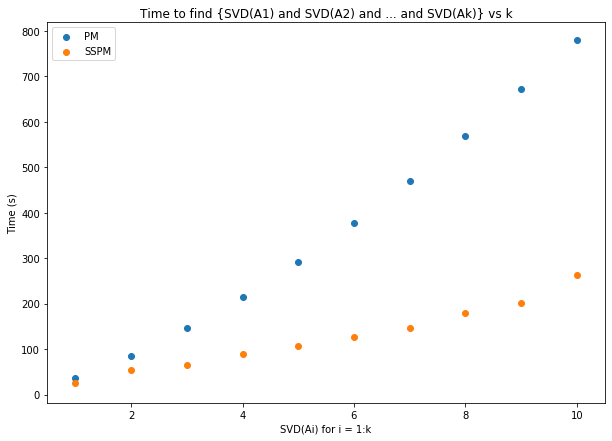

In [75]:
times = [i.time for i in PM_results['PM']]
perc = np.linspace(.1, 1, 10)
i_range = np.arange(1, 11)
fig = plt.figure(figsize=(10,7))
plt.scatter(i_range, np.cumsum(times), label = 'PM')
plt.scatter(i_range, np.cumsum(SSPM.time_iterations), label = 'SSPM')
plt.legend()
plt.title('Time to find {SVD(A1) and SVD(A2) and ... and SVD(Ak)} vs k')
plt.ylabel("Time (s)")
plt.xlabel('SVD(Ai) for i = 1:k')
plt.show()

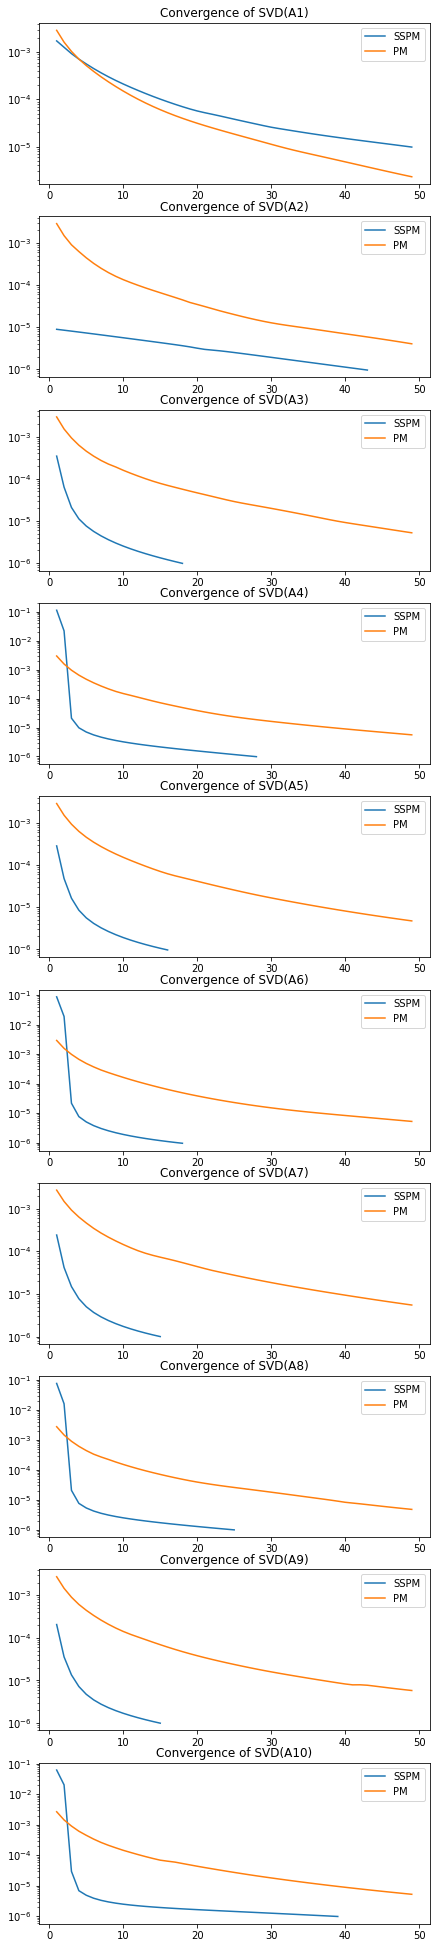

In [71]:
offset = 1
fig, axs = plt.subplots(10,1)
fig.set_figheight(12)
fig.set_figwidth(7)
for i, run in enumerate(SSPM.tol_iterations):
    num_iters_SSPM = len(run[offset:])
    num_iters_PM = len(PM_results['PM'][i].tol_iterations[offset:])
    axs[i].plot(range(1, 1+num_iters_SSPM), run[offset:], label='SSPM')
    axs[i].set_title('Convergence of SVD(A{})'.format(i+1))
    axs[i].plot(range(1, 1+num_iters_PM),
                PM_results['PM'][i].tol_iterations[offset:], label='PM')
    axs[i].set_yscale('log')
    axs[i].legend()

plt.subplots_adjust(top=2.2,bottom=0)
plt.show()
    

In [21]:
SSPM.time_iterations

[26.34222912788391,
 26.677455186843872,
 12.64366364479065,
 24.319468021392822,
 16.05701780319214,
 21.120814085006714,
 18.44426918029785,
 34.157915115356445,
 22.544888734817505,
 60.638391971588135]

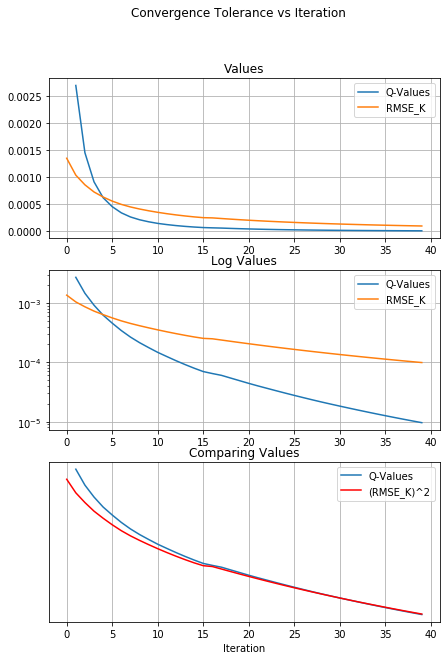

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(7)
ax1.plot(PM1.metrics['q-vals'], label='Q-Values')
ax1.plot(PM1.metrics['rmse'], label = 'RMSE_K')
ax1.legend()
ax1.set_title("Values")
ax1.grid()
ax2.plot(PM1.metrics['q-vals'], label='Q-Values')
ax2.plot(PM1.metrics['rmse'], label = 'RMSE_K')
ax2.set_yscale('log')
ax2.legend()
ax2.set_title("Log Values")
ax2.grid()
ax3.plot(PM1.metrics['q-vals'], label='Q-Values')
ax3.plot(1000*np.array(PM1.metrics['rmse'])**2, color='red',label = '(RMSE_K)^2')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title("Comparing Values")
ax3.set_xlabel('Iteration')
ax3.grid()
ax3.axes.get_yaxis().set_visible(False)
fig.suptitle('Convergence Tolerance vs Iteration')
plt.show()

In [11]:
SSPM = SuccessiveStochasticPowerMethod(k=k,
                                       max_sub_iter=50,
                                       buffer = b,
                                       scoring_method=score,
                                       sub_start='warm',
                                       tol=tol_limit,
                                       f=f,
                                       p=1,
                                       full_metric=False)
Us, Ss, Vs = SSPM.svd(snp_array.T)

Vshape (10, 20000)
Vshape (10, 20000)
Vshape (10, 20000)
5.5553063348497345
Vshape (10, 20000)
19.939947280287306
Vshape (10, 20000)
5.1757019507064825
Vshape (10, 20000)
18.337928409067136
Vshape (10, 20000)
4.661933222195977
Vshape (10, 20000)
17.823084417776396
Vshape (10, 20000)
4.7369501745134475
Vshape (10, 20000)
17.31411264173104


In [193]:
def q_vects(v1, v2, scale=False, norm=2):
    """

    :param vect_k:
    :param scale:
    :param p:
    :param norm:
    :return:

    Assume u_k are left singular vectors!
    """
    try:
        v1 = v1 if v1.shape[1] < v1.shape[0] else v1.T
        v2 = v2 if v2.shape[1] < v2.shape[0] else v2.T
        
        _, S, _ = np.linalg.svd((v1.T.dot(v2)).compute())
        print(S)
        return S

    except IndexError:
        return float('INF')

qvects3 = []
for i in range(len(SSPM.vector_iterations['V'])):
    if i == 0:
        continue
    else:
        qvects3.append(q_vects(SSPM.vector_iterations['V'][i], 
                               SSPM.vector_iterations['V'][i-1]))
        
        
        
        


[1.         0.95933259 0.93648973 0.80447407 0.70621908 0.56169075
 0.43129907 0.22639251 0.16037046 0.07519203]
[0.99628057 0.92237485 0.90135499 0.75912559 0.69833125 0.65387728
 0.58091195 0.33520854 0.24865644 0.084333  ]
[0.98718671 0.97484676 0.95170872 0.87917932 0.74525515 0.59322998
 0.54944794 0.39453586 0.05828451 0.01530442]
[0.97572915 0.94918921 0.8831463  0.79029042 0.61794888 0.55391814
 0.48005522 0.24786295 0.0597962  0.00216112]
[0.99929407 0.98191566 0.93770245 0.87742352 0.77858479 0.68346109
 0.52612379 0.35593166 0.30070844 0.09314181]
[0.99210885 0.96117495 0.93482261 0.82258296 0.62751815 0.42246075
 0.35669895 0.34431933 0.14182781 0.02300818]
[0.9907395  0.97591462 0.94274295 0.91543508 0.86711527 0.70038836
 0.62716161 0.50125333 0.24315126 0.13594297]
[0.99182727 0.97018077 0.95934659 0.92889264 0.88500812 0.61574875
 0.57123113 0.36942366 0.20907478 0.12259022]
[0.99351516 0.98234041 0.95696131 0.82466799 0.68919091 0.60356025
 0.49187062 0.40581625 0.1836

Text(0.5, 0, '% of Matrix Used')

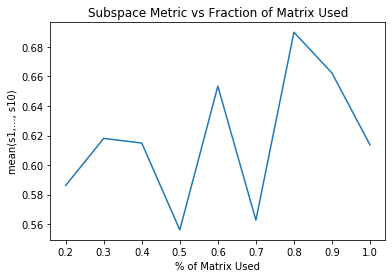

In [194]:
plt.plot(np.linspace(.2, 1, 9), np.mean(qvects3, axis=1))
plt.title("Subspace Metric vs Fraction of Matrix Used")
plt.ylabel("mean(s1,..., s10)")
plt.xlabel("% of Matrix Used")

Text(0.5, 0, '% of Matrix Used')

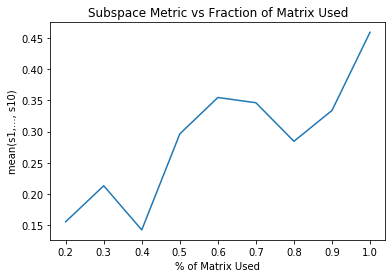

In [192]:
plt.plot(np.linspace(.2, 1, 9), np.mean(qvects3, axis=1))
plt.title("Subspace Metric vs Fraction of Matrix Used")
plt.ylabel("mean(s1,..., s10)")
plt.xlabel("% of Matrix Used")

In [174]:
tol_plt_inter = []
time_plt_iter = []
t0 = 0
for sub_list, time in zip(SSPM.tol_iterations, SSPM.time_iterations):
    tol_plt_inter += sub_list[1:]
    time_plt_iter += np.linspace(t0, t0+time, len(sub_list)-1).tolist()
    t0 += time
    

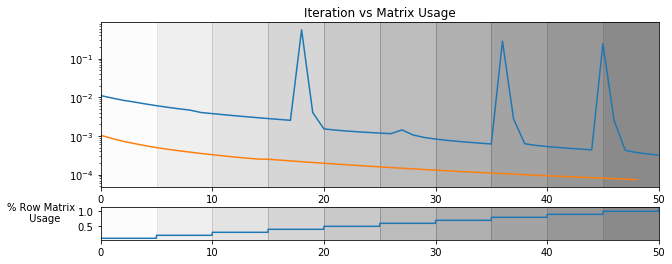

In [175]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]})
fig.set_figheight(4)
fig.set_figwidth(10)
ax1.plot(tol_plt_inter, label='SSPM')
ax1.plot(PM1.tol_iterations[1:], label = 'PM')
ax1.set_title('Iteration vs Matrix Usage')
ax1.set_xlim(0,50)
ax2.set_xlim(0,50)
#ax2.axes.get_yaxis().set_visible(False) 
N = 2000
ax2.plot(np.linspace(0, 50, N), np.floor(np.linspace(1, 11 ,N))/10)


ax2.set_ylabel('% Row Matrix \n Usage',rotation=0, labelpad=35, )

ax1.set_yscale('log')
for i in range(0, 50, 5):
    ax1.axvspan(i, i+5, alpha=(i+1)/50, color='grey')
    ax2.axvspan(i, i+5, alpha=(i+1)/50, color='grey')
plt.show()

In [74]:
np.floor(np.linspace(0, 50, N))

array([ 0.,  0.,  0., ..., 49., 49., 50.])

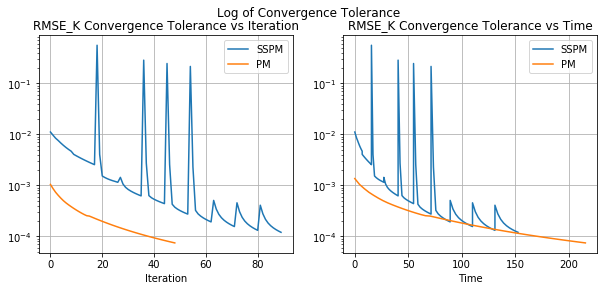

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)


ax1.set_yscale('log')
ax1.plot(tol_plt_inter, label='SSPM')
ax1.plot(PM1.tol_iterations[1:], label = 'PM')
ax1.set_title('RMSE_K Convergence Tolerance vs Iteration')
ax1.set_xlabel('Iteration')
ax1.legend()
ax1.grid()

ax2.set_yscale('log')
ax2.plot(time_plt_iter, tol_plt_inter, label='SSPM')
ax2.plot(np.linspace(0, PM1.time, maxiter), PM1.tol_iterations, label = 'PM')
ax2.set_title('RMSE_K Convergence Tolerance vs Time')
ax2.set_xlabel('Time')
ax2.legend()
ax2.grid()

fig.suptitle('Log of Convergence Tolerance')



plt.show()

In [17]:
list(range(5, 50+5, 5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

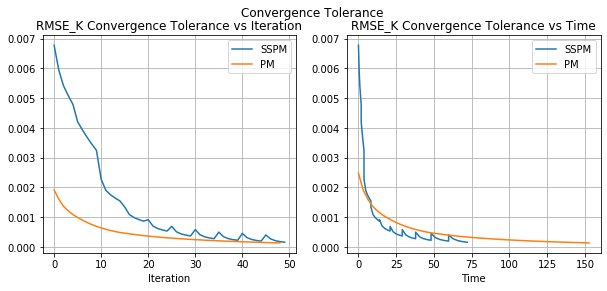

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

ax1.plot(tol_plt_inter, label='SSPM')
ax1.plot(PM1.tol_iterations[1:], label = 'PM')
ax1.set_title('RMSE_K Convergence Tolerance vs Iteration')
ax1.set_xlabel('Iteration')
ax1.legend()
ax1.grid()
ax2.plot(time_plt_iter, tol_plt_inter, label='SSPM')
ax2.plot(np.linspace(0, PM1.time, maxiter), PM1.tol_iterations, label = 'PM')
ax2.set_title('RMSE_K Convergence Tolerance vs Time')
ax2.set_xlabel('Time')
ax2.legend()
ax2.grid()

fig.suptitle('Convergence Tolerance')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.yscale('log')
plt.plot(tol_plt_inter, label='SSPM')
plt.plot(PM1.tol_iterations[1:], label = 'PM')

In [68]:
SSPM2 = SuccessiveStochasticPowerMethod(k=k,
                                        max_sub_iter=6,
                                        buffer = b,
                                        scoring_method=score,
                                        sub_start='warm',
                                        tol=tol_limit/100,
                                        f=f,
                                        p=1,
                                        full_metric=False)
Us, Ss, Vs = SSPM2.svd(snp_array.T)
print(SSPM2.time)

20.410371783750904
5.361327576842493
19.010590061091154
4.089049635006815
4.233900115816139
18.170145996875867
4.404574081485067
4.893485580767011
68.37993121147156


# Ratio of SubArray Eigenvalues vs Array Eigenvalues

In [69]:
PM3 = PowerMethod(max_iter=maxiter, k=k, buffer=b,
                  tol=tol_limit, scoring_method=score, track_metrics=True)
U, S, V = PM3.svd(snp_array.T)

In [67]:
Vs.shape

(6, 26)

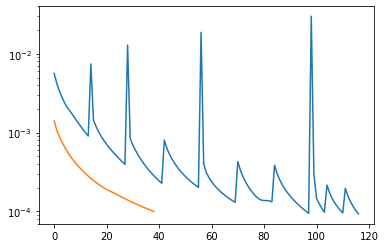

In [72]:
tol_plt_inter = []
for sub_list in SSPM.tol_iterations:
    tol_plt_inter += sub_list[1:]
plt.plot(tol_plt_inter)
plt.plot(PM3.tol_iterations)
plt.yscale('log')

In [11]:
Unp, Snp, Vnp = da.compute(*np.linalg.svd(snp_array[:, 0:20]))

In [13]:
Uqr, Sqr, Vqr = da.linalg.tsqr(snp_array[:, 0:20], compute_svd=True)

In [15]:
da.linalg.norm(Unp - Uqr).compute()

0.0

In [127]:
Sda.compute()

array([161.07276844,  29.40831642,  29.24509473,  28.99719264,
        28.91450405,  28.89533059,  28.79036772,  28.65630589,
        28.59974152,  28.31631912])

In [115]:
Uqr, Sqr, Vqr = da.linalg.tsqr(xda, compute_svd=True)

In [116]:
da.linalg.norm(Snp - Sqr).compute()

0.0

In [23]:
ratios = []
try:
    S = S.compute()
except:
    S = S
    
p = len(SSPM.value_iterations)
k = len(SSPM.value_iterations[0][0])
for i in range(p):
    sub_ratios = [SSPM.value_iterations[p-1][-1][j]/
                  SSPM.value_iterations[i][-1][j] for j in range(k)]
    ratios.append(sub_ratios)

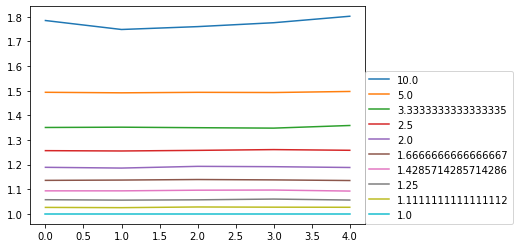

In [24]:
for i, r in enumerate(ratios):
    plt.plot(r[0:5], label=SSPM.value_scalers[i])
plt.legend(loc=(1,0))

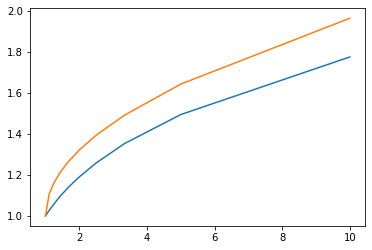

In [36]:
avg_ratio = [np.mean(r[0:5]) for r in ratios]

plt.plot(SSPM.value_scalers, avg_ratio)

def eigen_scaler_sqrt(x):
    return .321*np.sqrt(np.array(x)-1) + 1

def eigen_scaler_ln(x):
    return .365*np.log(x) + 1

plt.plot(SSPM.value_scalers, eigen_scaler_sqrt(SSPM.value_scalers))